<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Standardise-text" data-toc-modified-id="Standardise-text-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Standardise text</a></span></li><li><span><a href="#Words-per-article" data-toc-modified-id="Words-per-article-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Words per article</a></span></li><li><span><a href="#Word-frequency" data-toc-modified-id="Word-frequency-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Word frequency</a></span></li><li><span><a href="#N-grams" data-toc-modified-id="N-grams-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>N-grams</a></span><ul class="toc-item"><li><span><a href="#Bigrams" data-toc-modified-id="Bigrams-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Bigrams</a></span></li><li><span><a href="#Trigrams" data-toc-modified-id="Trigrams-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Trigrams</a></span></li></ul></li><li><span><a href="#Export" data-toc-modified-id="Export-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Export</a></span></li><li><span><a href="#Topic-modelling" data-toc-modified-id="Topic-modelling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Topic modelling</a></span></li><li><span><a href="#Sentiment-analysis" data-toc-modified-id="Sentiment-analysis-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Sentiment analysis</a></span></li><li><span><a href="#NER" data-toc-modified-id="NER-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>NER</a></span></li></ul></div>

## Preamble

In [1]:
import pandas as pd
import json
import pickle
import re
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

## Load data

In [2]:
train = pd.read_csv("../data/train.csv")
print(train.shape)
test = pd.read_csv("../data/test.csv")
print(test.shape)

(120000, 3)
(7600, 3)


In [3]:
train.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Apply class map to get raw class labels

In [4]:
with open('../data/classes.json') as f:
    class_map = json.load(f)
    
class_map_inv = {v:k for k, v in class_map.items()}

In [5]:
train['class'] = train['Class Index'].map(class_map_inv)
test['class'] = test['Class Index'].map(class_map_inv)

In [6]:
print(train['class'].value_counts())
print(test['class'].value_counts())

business        30000
science/tech    30000
sports          30000
world           30000
Name: class, dtype: int64
business        1900
science/tech    1900
sports          1900
world           1900
Name: class, dtype: int64


In [7]:
TOPICS = train['class'].unique().tolist()

## Standardise text

In [8]:
train['text'] = train['Title'] + ' : ' + train['Description']

Find unique characters across all text

In [9]:
print(set(''.join(train['text'])))

{'h', '(', 's', 'K', 'P', '-', ')', 'v', 'Y', 'p', 't', '#', '6', 'z', '7', '3', 'D', 'k', 'j', 'n', '0', '_', 'I', 'e', 'r', '?', '*', 'J', 'X', '2', 'l', 'O', '1', 'q', '4', 'N', 'w', '$', '5', 'V', 'M', '/', 'T', '8', 'i', 'H', 'F', 'Z', ' ', 'a', 'x', 'W', 'u', 'S', '9', ':', 'b', '&', 'A', 'd', ',', 'c', 'R', 'y', 'f', '"', "'", 'C', 'm', 'L', 'g', '!', 'U', 'G', '\\', 'B', 'o', 'Q', ';', '.', '=', 'E'}


In [10]:
# Replace hyphens and remove website suffix
train['text_cleaned'] = train['text'].apply(lambda x: x.replace('-', ' ').replace('\\', ' ').replace('.com', '')\
                                            .replace('B&gt;', ' ').replace('&lt;', ' ').replace('br&gt;', ' ')\
                                            .replace('&gt;', ' ').replace('/b', ''))

# Remove hyperlinks
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: re.sub('HREF="[^&]+"', '', x))

# Remove Reuters ref - this includes location so needs Regex matching
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: re.sub(': [^&]+(Reuters)', '', x))

# Remove punctuation
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Remove words containing numbers
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: re.sub(r'\w*\d\w*', '', x).strip())

# Convert to lowercase
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: x.lower())

# Remove publication names
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: x.replace('ziff davis', '')\
                                                    .replace('canadian press', '')\
                                                    .replace('the washington post', '')\
                                                    .replace('reuters', '')\
                                                   .replace('afp', ''))

In [11]:
for i in range(5):
    print(i)
    print("raw:", train['text'].iloc[i])
    print("cleaned:", train['text_cleaned'].iloc[i])

0
raw: Wall St. Bears Claw Back Into the Black (Reuters) : Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.
cleaned: wall st bears claw back into the black      short sellers wall streets dwindling band of ultra cynics are seeing green again
1
raw: Carlyle Looks Toward Commercial Aerospace (Reuters) : Reuters - Private investment firm Carlyle Group,\which has a reputation for making well-timed and occasionally\controversial plays in the defense industry, has quietly placed\its bets on another part of the market.
cleaned: carlyle looks toward commercial aerospace      private investment firm carlyle group which has a reputation for making well timed and occasionally controversial plays in the defense industry has quietly placed its bets on another part of the market
2
raw: Oil and Economy Cloud Stocks' Outlook (Reuters) : Reuters - Soaring crude prices plus worries\about the economy and the outlook for earnings are expected to\hang over the 

Tokenize

In [12]:
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: x.split())

Remove stopwords

In [13]:
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: [word for word in x if word not in stopwords.words('english')])

## Words per article

In [14]:
num_words_per_article = train['text_cleaned'].apply(lambda x: len(x))
num_uniq_words_per_article = train['text_cleaned'].apply(lambda x: len(np.unique(x)))

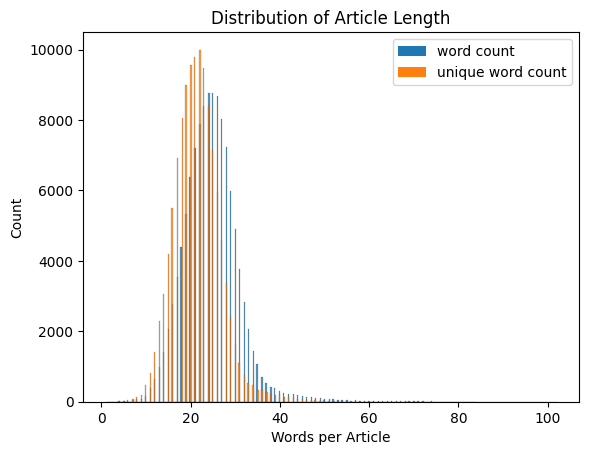

In [15]:
fig, ax = plt.subplots()
a = sns.histplot(num_words_per_article, ax=ax, label='word count')
b = sns.histplot(num_uniq_words_per_article, ax=ax, label='unique word count')
ax.set_xlabel('Words per Article')
ax.set_title('Distribution of Article Length')

handles, labels = ax.get_legend_handles_labels()
n = len(handles)
ax.legend([handles[i] for i in range(n) if i not in [1, 3]],
          [labels[i] for i in range(n) if i not in [1, 3]])

plt.show()

Not much difference between word count vs. unique word count - suggests limited repetition per article.

## Word frequency

In [16]:
word_counters = dict.fromkeys(train['class'].unique())

In [17]:
for topic in TOPICS:
    word_counters[topic] = Counter(train[train['class'] == topic]['text_cleaned'].sum())
    print(topic, word_counters[topic].most_common(20))

business [('us', 9228), ('said', 7230), ('oil', 6316), ('new', 4712), ('inc', 4225), ('prices', 4208), ('company', 4097), ('percent', 3435), ('year', 3262), ('corp', 2944), ('profit', 2882), ('million', 2878), ('quarter', 2780), ('sales', 2767), ('stocks', 2689), ('monday', 2612), ('billion', 2588), ('wednesday', 2582), ('tuesday', 2557), ('thursday', 2482)]
science/tech [('new', 7045), ('microsoft', 4889), ('ap', 3706), ('said', 3686), ('software', 3652), ('internet', 3354), ('us', 2647), ('space', 2640), ('company', 2625), ('search', 2312), ('first', 2254), ('computer', 2215), ('security', 2211), ('service', 2209), ('inc', 2189), ('music', 2148), ('technology', 2111), ('web', 2106), ('year', 2056), ('online', 2047)]
sports [('ap', 6260), ('game', 4264), ('first', 4241), ('new', 3887), ('season', 3600), ('win', 3438), ('team', 3379), ('two', 3344), ('one', 3215), ('night', 3006), ('world', 2988), ('last', 2864), ('cup', 2758), ('league', 2719), ('victory', 2647), ('year', 2598), ('sun

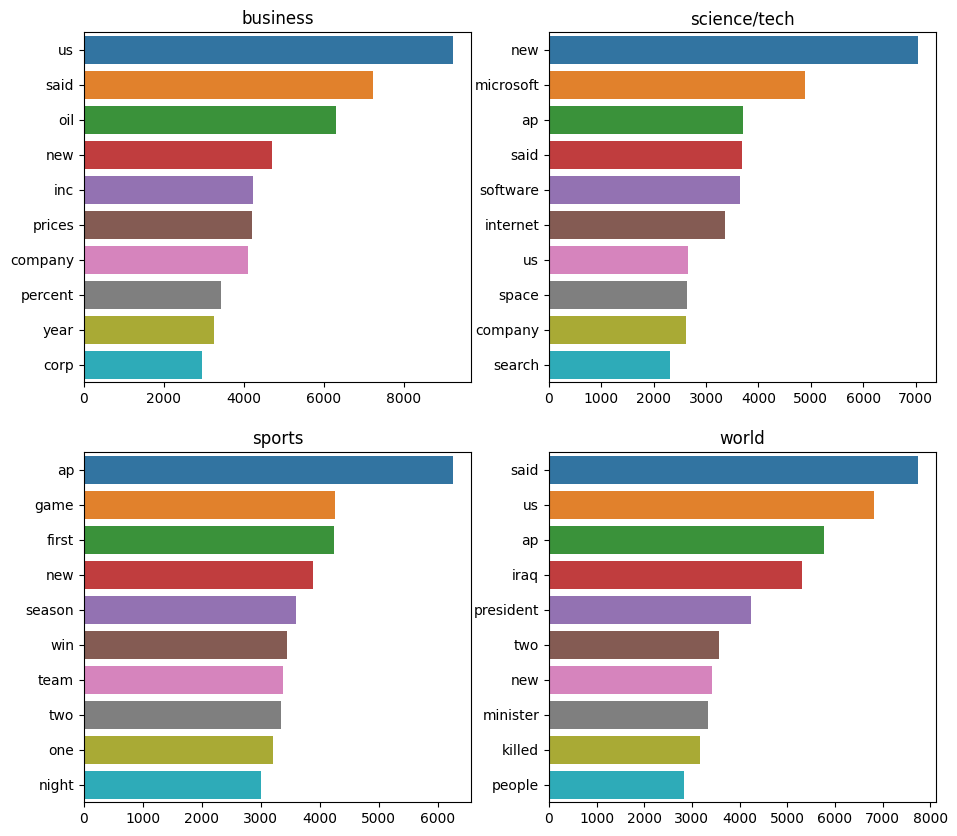

In [18]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(11,10))

for i, topic in enumerate(TOPICS):
    
    y_ind = i % 2
    x_ind = ceil((i+1)/2) - 1
    
    words, counts = list(map(list,zip(*word_counters[topic].most_common(10))))
    sns.barplot(x=counts, y=words, ax=ax[x_ind, y_ind])
    ax[x_ind, y_ind].set_title(topic)

Looks like we have some untreated words which occur frequently and don't add meaning.

Check crossover in top 50 words across topics

In [19]:
top_words = []

for topic in TOPICS:
    top_words.extend([w[0] for w in word_counters[topic].most_common(50)])
    
dup_top_words = [(w, top_words.count(w)) for w in set(top_words)]
dup_top_words = sorted(dup_top_words, key=lambda x: x[1], reverse=True)

In [20]:
dup_top_words[:20]

[('year', 4),
 ('two', 4),
 ('us', 4),
 ('said', 4),
 ('tuesday', 4),
 ('thursday', 4),
 ('first', 4),
 ('new', 4),
 ('wednesday', 3),
 ('world', 3),
 ('ap', 3),
 ('monday', 3),
 ('friday', 3),
 ('one', 3),
 ('yesterday', 3),
 ('york', 2),
 ('corp', 2),
 ('united', 2),
 ('market', 2),
 ('may', 2)]

Remove additional stopwords

In [21]:
extra_stopwords = [word for word, count in dup_top_words if count > 2]
#TODO extra_stopwords = ['year', 'thursday', 'two', 'said', 'reuters', 'new', 'tuesday', 'first', 'us', 'one', 'monday', 'yesterday', 'friday', 'wednesday', 'ap', 'world']

# add days of the week
extra_stopwords +=  ['saturday', 'sunday']

# add words found from N-grams
extra_stopwords +=  ['font', 'faceverdanams','sans','serifarialhelvetica']
print(extra_stopwords)

['year', 'two', 'us', 'said', 'tuesday', 'thursday', 'first', 'new', 'wednesday', 'world', 'ap', 'monday', 'friday', 'one', 'yesterday', 'saturday', 'sunday', 'font', 'faceverdanams', 'sans', 'serifarialhelvetica']


In [22]:
train['text_cleaned'] = train['text_cleaned'].apply(lambda x: [word for word in x if word not in extra_stopwords])

In [23]:
for topic in TOPICS:
    word_counters[topic] = Counter(train[train['class'] == topic]['text_cleaned'].sum())
    print(topic, word_counters[topic].most_common(20))

business [('oil', 6316), ('inc', 4225), ('prices', 4208), ('company', 4097), ('percent', 3435), ('corp', 2944), ('profit', 2882), ('million', 2878), ('quarter', 2780), ('sales', 2767), ('stocks', 2689), ('billion', 2588), ('shares', 2250), ('third', 2091), ('group', 1995), ('market', 1909), ('dollar', 1899), ('business', 1850), ('largest', 1795), ('earnings', 1765)]
science/tech [('microsoft', 4889), ('software', 3652), ('internet', 3354), ('space', 2640), ('company', 2625), ('search', 2312), ('computer', 2215), ('security', 2211), ('service', 2209), ('inc', 2189), ('music', 2148), ('technology', 2111), ('web', 2106), ('online', 2047), ('ibm', 1905), ('mobile', 1869), ('google', 1789), ('corp', 1746), ('windows', 1704), ('could', 1689)]
sports [('game', 4264), ('season', 3600), ('win', 3438), ('team', 3379), ('night', 3006), ('last', 2864), ('cup', 2758), ('league', 2719), ('victory', 2647), ('three', 2338), ('coach', 2306), ('time', 2183), ('second', 2120), ('lead', 2082), ('back', 19

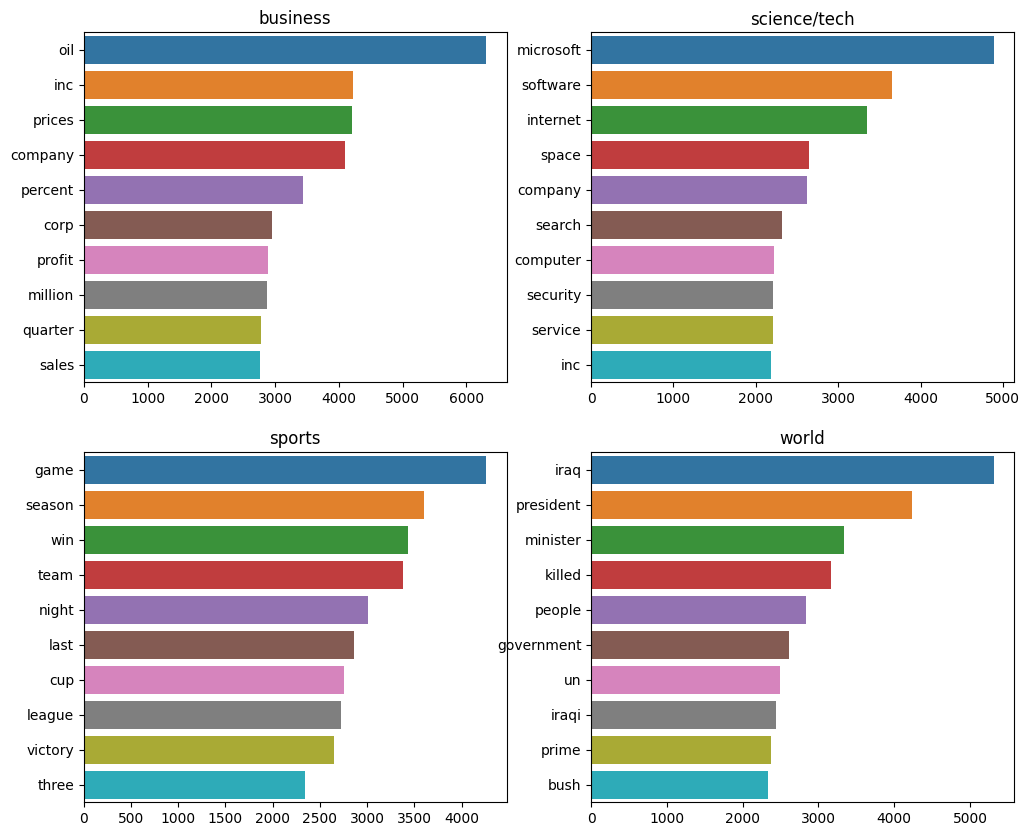

In [24]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, topic in enumerate(TOPICS):
    
    y_ind = i % 2
    x_ind = ceil((i+1)/2) - 1
    
    words, counts = list(map(list,zip(*word_counters[topic].most_common(10))))
    sns.barplot(x=counts, y=words, ax=ax[x_ind, y_ind])
    ax[x_ind, y_ind].set_title(topic)

Looking like a more informative set of words.

## N-grams

In [25]:
def get_top_ngrams(corpus, n=None, num_to_return=100):

    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:num_to_return]

### Bigrams

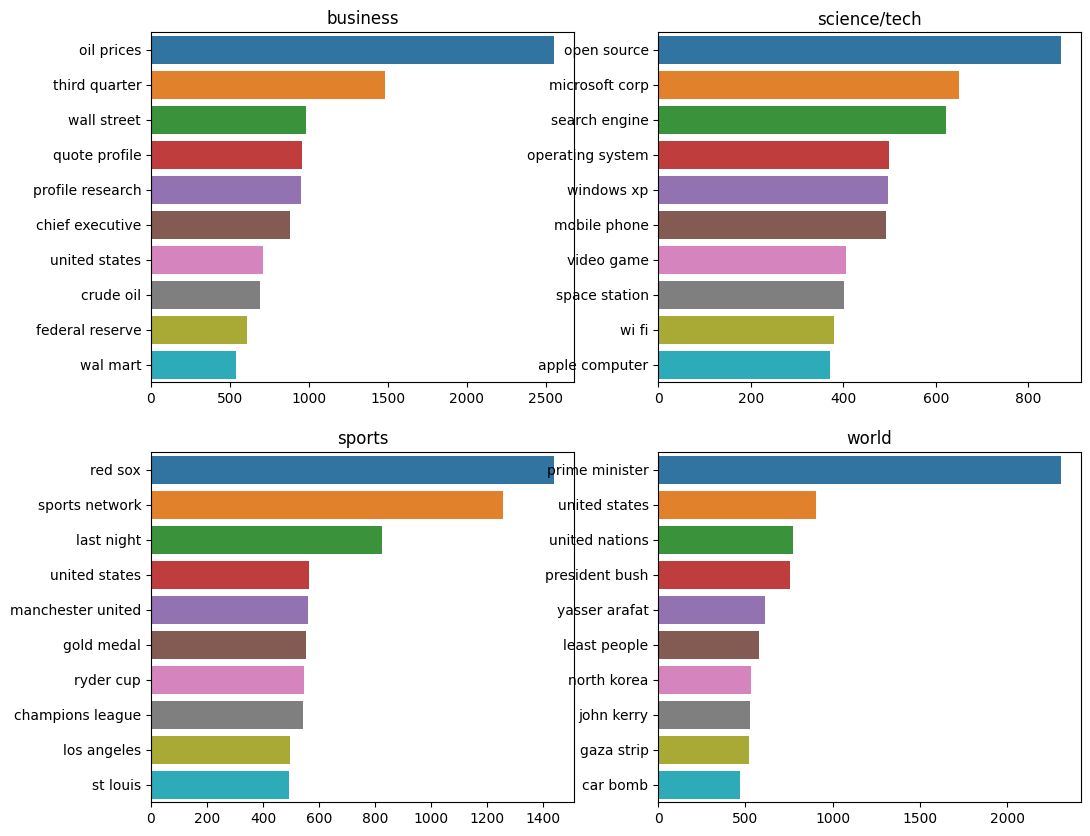

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, topic in enumerate(TOPICS):
    
    y_ind = i % 2
    x_ind = ceil((i+1)/2) - 1
    
    top_bigrams = get_top_ngrams(train[train['class'] == topic]['text_cleaned'].apply(lambda x: ' '.join(x)), 2)
    
    words, counts = list(map(list,zip(*top_bigrams[:10])))
    sns.barplot(x=counts, y=words, ax=ax[x_ind, y_ind])
    ax[x_ind, y_ind].set_title(topic)

### Trigrams

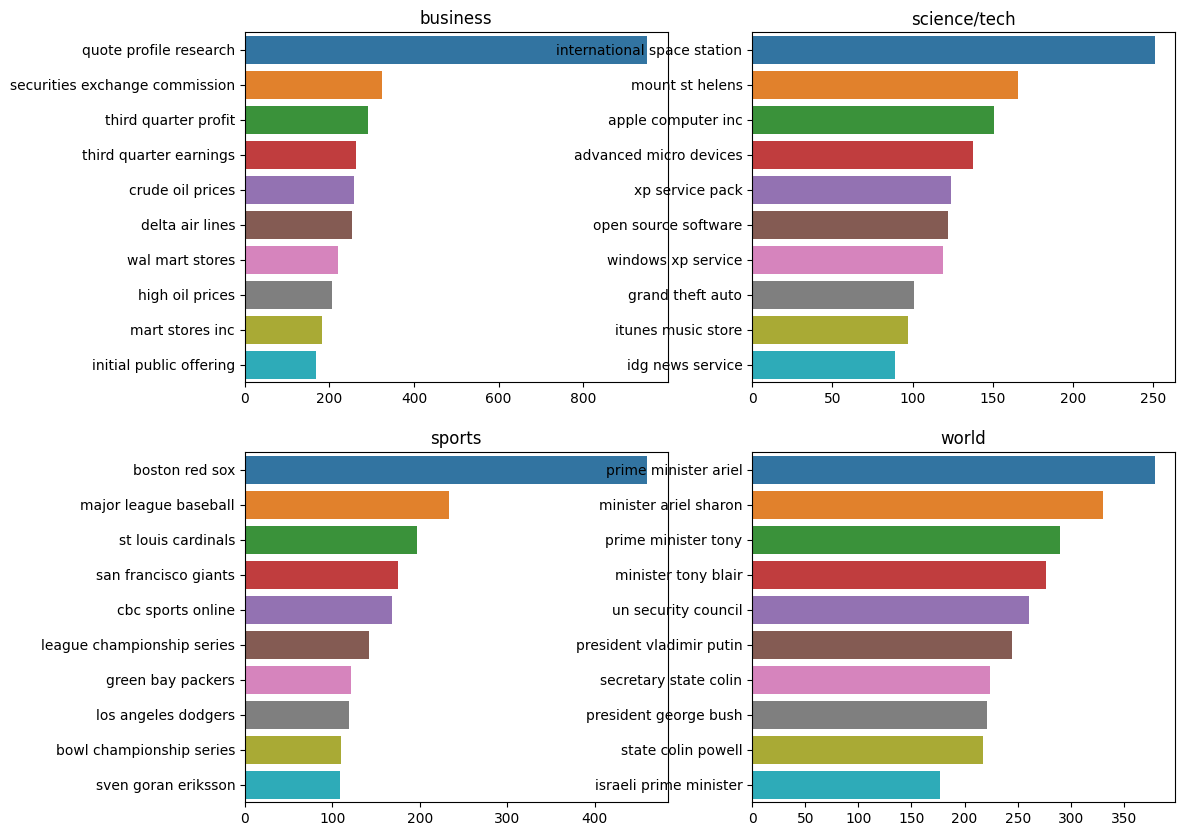

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

for i, topic in enumerate(TOPICS):
    
    y_ind = i % 2
    x_ind = ceil((i+1)/2) - 1
    
    top_trigrams = get_top_ngrams(train[train['class'] == topic]['text_cleaned'].apply(lambda x: ' '.join(x)), 3)
    
    words, counts = list(map(list,zip(*top_trigrams[:10])))
    sns.barplot(x=counts, y=words, ax=ax[x_ind, y_ind])
    ax[x_ind, y_ind].set_title(topic)

## Export

Save extra stopwords and cleaned text

In [30]:
train.to_csv("../data/train_cleaned.csv", index=False)

In [29]:
with open("../artefacts/extra_stopwords.pkl", "wb") as f:
    pickle.dump(extra_stopwords, f)

## Topic modelling

## Sentiment analysis

## NER